In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from statsmodels.robust.scale import mad

from lightkurve import KeplerLightCurveFile

from BEER_curve import BEER_curve
from BEER_curve.utils import median_boxcar_filter, bindata

from PyAstronomy.pyasl import isInTransit

(1000, 1000)


(-0.0001, 0.0001)

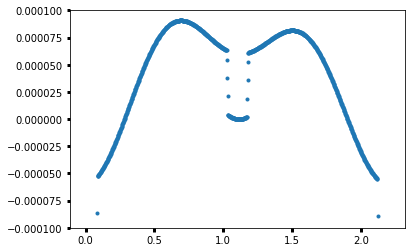

In [2]:
params = {
    "per": 2.204733,
    "a": 4.15,
    "T0": 0.,
    "p": 1./12.85,
    "linLimb" : 0.314709,
    "quadLimb" : 0.312125,
    "b": 0.499,
    "Aellip": 37.e-6,
    "Abeam": 5.e-6,
    "F0": 0.,
    "Aplanet": 60.e-6,
    "phase_shift": 0.
}

time = np.linspace(0, 2*params['per'], 1000)

BC = BEER_curve(time, params, supersample_factor=7, exp_time=10./60./24.)
y = BC.all_signals()
print(y.size, time.size)

plt.scatter(time % params['per'], y, marker='.')
plt.ylim([-0.0001, 0.0001])
#plt.ylim([1 - 0.0001, 1 + 0.0001])
#plt.ylim([2 - 0.0001, 2 + 0.0001])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 1000
    # variables        = 4
    chi-square         = 2.3688e-08
    reduced chi-square = 2.3783e-11
    Akaike info crit   = -24458.0600
    Bayesian info crit = -24438.4290
[[Variables]]
    per:          2.204733 (fixed)
    a:            4.15 (fixed)
    T0:           0 (fixed)
    p:            0.07782101 (fixed)
    linLimb:      0.314709 (fixed)
    quadLimb:     0.312125 (fixed)
    b:            0.499 (fixed)
    Aellip:       3.7000e-05 +/- 1.7489e-07 (0.47%) (init = 3.7e-05)
    Abeam:        5.0000e-06 +/- 2.1832e-07 (4.37%) (init = 5e-06)
    F0:           4.9733e-07 +/- 1.1317e-15 (0.00%) (init = 0)
    Aplanet:      6.0000e-05 +/- 2.3424e-07 (0.39%) (init = 6e-05)
    phase_shift:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(Aellip, F0) = -0.694


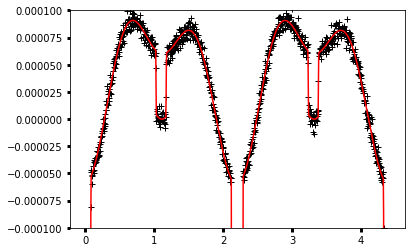

In [3]:
#Now trying to learn how to use lmfit - https://lmfit.github.io/lmfit-py/parameters.html#simple-example
from lmfit import Minimizer, Parameters, report_fit
from numpy.random import normal

# define objective function: returns the array to be minimized
def fcn2min(params, time, data):
    
    BC = BEER_curve(time, params, supersample_factor=7, exp_time=10./60./24.)    
    model = BC.all_signals()
    
    return model - data

std = 5e-6 # scatter
noisy_y = y + std*normal(size=len(y))

# create a set of Parameters
params = Parameters()
params.add('per', value=2.204733, vary=False)
params.add('a', value=4.15, vary=False)
params.add('T0', value=0., vary=False)
params.add('p', value=1./12.85, vary=False)
params.add('linLimb', value=0.314709, vary=False)
params.add('quadLimb', value=0.312125, vary=False)
params.add('b', value=0.499, vary=False)
params.add('Aellip', value=37.e-6, min=0., max=100e-6)
params.add('Abeam', value=5.e-6, min=0., max=10e-6)
params.add('F0', value=0., min=0., max=100e-6)
params.add('Aplanet', value=60.e-6, min=0., max=100e-6)
params.add('phase_shift', value=0., vary=False)

# do fit, here with leastsq model
data = noisy_y
minner = Minimizer(fcn2min, params, fcn_args=(time, data))
result = minner.minimize()

# calculate final result
final = data + result.residual

# write error report
report_fit(result)

# try to plot results
try:
    plt.plot(time, data, 'k+')
    plt.plot(time, final, 'r')
    plt.ylim([-0.0001, 0.0001])
except ImportError:
    pass

In [5]:
time = np.array([])
flux = np.array([])

for q in range(0,18):
    lc = KeplerLightCurveFile.from_archive('HAT-P-7b', quarter=q, verbose=False).SAP_FLUX
    cur_time = lc.time
    cur_flux = lc.flux
    cur_flux = (cur_flux - np.nanmedian(cur_flux))/np.nanmedian(cur_flux)

    filtered_flux = cur_flux
    
    window = 2.*params['per']
    del_t = np.median(np.max(cur_time[1:]) - np.max(cur_time[:-1]))
    window_length = int(window/del_t)

    filt = median_boxcar_filter(cur_flux, window_length)
    filtered_flux = cur_flux - filt
    
    time = np.append(time, cur_time)
    flux = np.append(flux, filtered_flux)

(-0.008, 0.001)

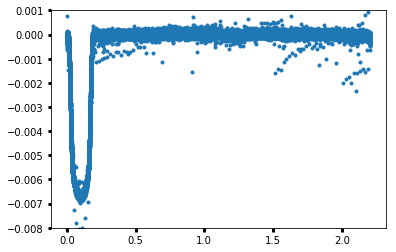

In [6]:
folded_time = time % params['per']
plt.scatter(folded_time, flux, marker='.')
plt.ylim([-0.008, 0.001])

In [7]:
binsize = 10./60./24.
binned_time, binned_data, binned_err = bindata(folded_time, flux, binsize, bin_calc='mean')

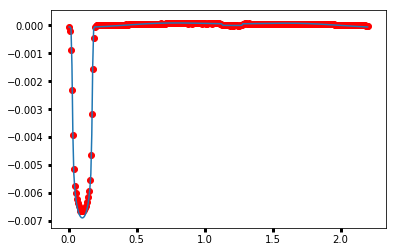

In [8]:
params = {
    "per": 2.204733,
    "a": 4.15,
    "T0": binned_time[np.argmin(binned_data)], 
    "p": (1./12.85),
    "linLimb" : 0.314709, 
    "quadLimb" : 0.312125,
    "b": 0.499,
    "Aellip": 37.e-6,
    "Abeam": 5.e-6,
    "F0": 0.,
    "Aplanet": 60.e-6,
    "phase_shift": 0.
}

BC = BEER_curve(binned_time, params, data=binned_data, supersample_factor=7, exp_time=10./60./24.)
y = BC.all_signals()
plt.plot(binned_time, y)
plt.scatter(binned_time, binned_data, color='red')
# plt.axhline(0)
# plt.ylim([-0.0001, 0.0001])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 317
    # variables        = 8
    chi-square         = 4447.82372
    reduced chi-square = 14.3942515
    Akaike info crit   = 853.282092
    Bayesian info crit = 883.353306
[[Variables]]
    per:          2.204733 (fixed)
    a:            2.70588329 +/- 0.00815211 (0.30%) (init = 4.15)
    T0:           0.09907738 +/- 9.9686e-05 (0.10%) (init = 0.1007138)
    p:            0.08429278 +/- 9.3357e-05 (0.11%) (init = 0.09486833)
    b:            0.83834194 +/- 0.00148860 (0.18%) (init = 0.499)
    a1:           0.3802264 (fixed)
    a2:           0.7644142 (fixed)
    a3:          -0.6355133 (fixed)
    a4:           0.2007113 (fixed)
    Aellip:       1.6157e-05 +/- 1.0253e-06 (6.35%) (init = 1e-05)
    Abeam:        5.0410e-06 +/- 9.1095e-07 (18.07%) (init = 5e-06)
    F0:           2.8523e-05 +/- 1.3683e-06 (4.80%) (init = 0)
    Aplanet:      3.6129e-05 +/- 1.1368e-06 (3.15%) (

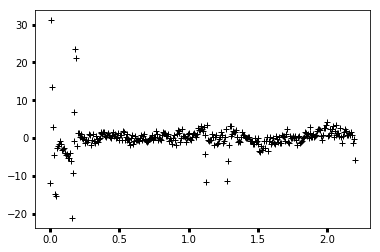

In [9]:
#Now trying to learn how to use lmfit - https://lmfit.github.io/lmfit-py/parameters.html#simple-example
from lmfit import Minimizer, Parameters, report_fit, Model
from numpy.random import normal

def calc_model(params, time):
    BC = BEER_curve(time, params)
    return BC.all_signals()    

# define objective function: returns the array to be minimized
def fcn2min(params, time, data, err):
    
    model = calc_model(params, time)

    return (model - data)/err

# create a set of Parameters
T0 = binned_time[np.argmin(binned_data)]
params = Parameters()
params.add('per', value=2.204733, vary=False)
params.add('a', value=4.15, min=2., max=5.)
params.add('T0', value=T0, min=0.93*T0, max=1.06*T0)
params.add('p', value=np.sqrt(0.009), min=0, max=0.2)
params.add('b', value=0.499, min=-1, max=1)
# params.add('linLimb', value=0.314709, min=0, max=1)#vary=False)
# params.add('quadLimb', value=0.312125, min=0, max=1)#, vary=False)

# Parameters from limb-darkening package - https://github.com/nespinoza/limb-darkening
params.add('a1', value=0.38022644, vary=False)
params.add('a2', value=0.76441418, vary=False)
params.add('a3', value=-0.63551326, vary=False)
params.add('a4', value=0.20071131, vary=False)

# params.add('Aellip', value=0., vary=False)
# params.add('Abeam', value=0., vary=False)
# params.add('F0', value=0., vary=False)
# params.add('Aplanet', value=0, vary=False)
# params.add('phase_shift', value=0., vary=False)

params.add('Aellip', value=10.e-6, min=0., max=100e-6)
params.add('Abeam', value=5.e-6, min=0., max=100e-6)
params.add('F0', value=0., min=0., max=100e-6)
params.add('Aplanet', value=60.e-6, min=0., max=100e-6)
params.add('phase_shift', value=0., vary=False)

# do fit, here with leastsq model
minner = Minimizer(fcn2min, params, fcn_args=(binned_time, binned_data, binned_err))
result = minner.minimize()
best_fit_params = result.params.valuesdict()

# calculate final result
final = calc_model(best_fit_params, binned_time)

# write error report
report_fit(result)

plt.plot(binned_time, (binned_data - final)/binned_err, 'k+')
# plt.plot(binned_time, final, 'r')
# plt.ylim([-0.0003, 0.0003])
# plt.plot(binned_time, np.abs(result.residual/binned_data), 'k+')

# plt.plot(binned_time, binned_data, 'k+')
# plt.plot(binned_time, final, 'r')

In [14]:
# KOI-13 data - From Herman+ (2018)
params = {
    "per": 1.76336,
    "a": 1./0.2205,
    "T0": 0., 
    "p": 0.0905,
    "linLimb" : 0.314709, 
    "quadLimb" : 0.312125,
    "b": 0.499,
    "Aellip": 37.e-6,
    "Abeam": 5.e-6,
    "F0": 0.,
    "Aplanet": 60.e-6,
    "phase_shift": 0.
}

time = np.array([])
flux = np.array([])

for q in range(0,18):
    lc = KeplerLightCurveFile.from_archive('KOI-13', quarter=q, verbose=False).SAP_FLUX
    cur_time = lc.time
    cur_flux = lc.flux
    cur_flux = (cur_flux - np.median(cur_flux))/np.median(cur_flux)

    filtered_flux = cur_flux
    
    window = 2.*params['per']
    del_t = np.median(np.max(cur_time[1:]) - np.max(cur_time[:-1]))
    window_length = int(window/del_t)
    # Make number odd
    if(window_length % 2 == 0):
        window_length += 1

    filt = median_boxcar_filter(cur_flux, window_length)
    filtered_flux = cur_flux - filt
    
    time = np.append(time, cur_time)
    flux = np.append(flux, filtered_flux)

INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2009131105131_llc.fits with expected size 77760. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2009166043257_llc.fits with expected size 192960. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2009259160929_llc.fits with expected size 466560. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2009350155506_llc.fits with expected size 466560. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2010078095331_llc.fits with expected size 469440. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr009941662_lc_Q111111111111111111/kplr009941662-2010174085026_llc.fits with expected size 492480. [astroquery.query]
INFO:

(-0.0002, 0.0002)

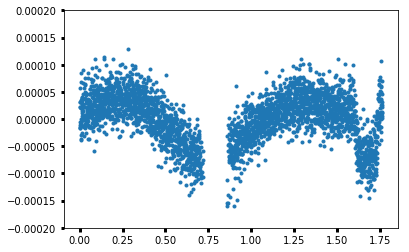

In [15]:
folded_time = time % params['per']
plt.scatter(folded_time, flux, marker='.')
plt.ylim([-0.0002, 0.0002])

(-0.0002, 0.0002)

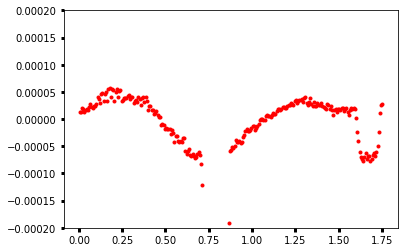

In [16]:
binsize = 10./60./24.
binned_time, binned_data, binned_err = bindata(folded_time, flux, binsize, bin_calc='mean')
plt.scatter(binned_time, binned_data, color='red', marker='.')
plt.ylim([-0.0002, 0.0002])

(-0.007, 0.005)

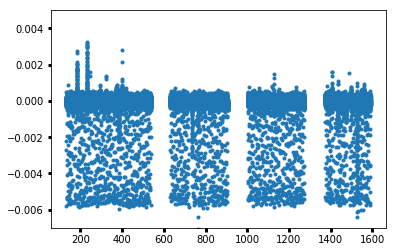

In [52]:
#Kepler-76 b
params = {
    'per': 1.54492875
}

time = np.array([])
flux = np.array([])

file_list = glob("mastDownload/Kepler/kplr004570949_lc/*llc.fits")

for cur_file in file_list:
    lc = KeplerLightCurveFile(cur_file).SAP_FLUX
    cur_time = lc.time
    cur_flux = lc.flux
    cur_flux = (cur_flux - np.nanmedian(cur_flux))/np.nanmedian(cur_flux)

    filtered_flux = cur_flux
    
    window = 2.*params['per']
    del_t = np.median(np.max(cur_time[1:]) - np.max(cur_time[:-1]))
    window_length = int(window/del_t)
    # Make number odd
    if(window_length % 2 == 0):
        window_length += 1

    filt = median_boxcar_filter(cur_flux, window_length)
    filtered_flux = cur_flux - filt    
    
    time = np.append(time, cur_time)
    flux = np.append(flux, filtered_flux)
    
plt.scatter(time, flux, marker='.')
plt.ylim([-0.007, 0.005])

(-0.0075, 0.0003)

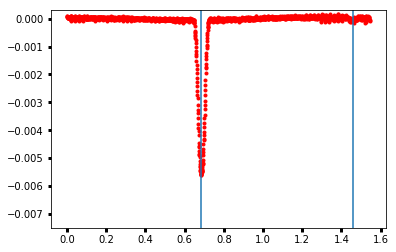

In [49]:
binsize = 1./60./24.
binned_time, binned_data, binned_err = bindata(folded_time, flux, binsize, bin_calc='mean')

T0 = binned_time[np.argmin(binned_data)]
TE = T0 + 0.5*params["per"]

plt.scatter(binned_time, binned_data, color='red', marker='.')
plt.axvline(T0)
plt.axvline(TE)
plt.ylim([-0.0075, 0.0003])

INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2009131105131_llc.fits with expected size 77760. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2009166043257_llc.fits with expected size 192960. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2009259160929_llc.fits with expected size 466560. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2009350155506_llc.fits with expected size 466560. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2010009091648_llc.fits with expected size 132480. [astroquery.query]
INFO: Found cached file ./mastDownload/Kepler/kplr011446443_lc_Q111111110111011101/kplr011446443-2010174085026_llc.fits with expected size 492480. [astroquery.query]
INFO:

(-0.007, 0.005)

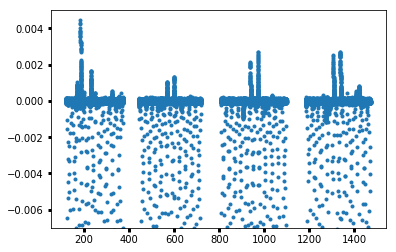

In [55]:
#Including TrES-2 - From Esteves+ (2015)
params = {
    'per' : 2.47061317
}
time = np.array([])
flux = np.array([])

for q in range(0,17):
    try:
        lc = KeplerLightCurveFile.from_archive('TrES-2', quarter=q, verbose=False).SAP_FLUX
        cur_time = lc.time
        cur_flux = lc.flux
        cur_flux = (cur_flux - np.nanmedian(cur_flux))/np.nanmedian(cur_flux)

        filtered_flux = cur_flux
    
        window = 2.*params['per']
        del_t = np.median(np.max(cur_time[1:]) - np.max(cur_time[:-1]))
        window_length = int(window/del_t)
        # Make number odd
        if(window_length % 2 == 0):
            window_length += 1

        filt = median_boxcar_filter(cur_flux, window_length)
        filtered_flux = cur_flux - filt    
    
        time = np.append(time, cur_time)
        flux = np.append(flux, filtered_flux)
    except:
        pass
    
plt.scatter(time, flux, marker='.')
plt.ylim([-0.007, 0.005])

(-0.015, 0.005)

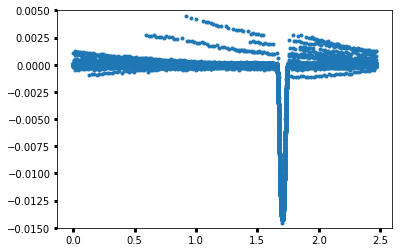

In [57]:
plt.scatter(time % params['per'], flux, marker='.')
plt.ylim([-0.015, 0.005])

(-0.001, 0.001)

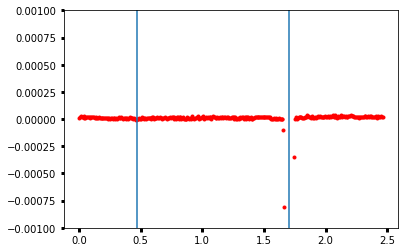

In [72]:
folded_time = time % params['per']

binsize = 10./60./24.
binned_time, binned_data, binned_err = bindata(folded_time, flux, binsize, bin_calc='mean')

T0 = binned_time[np.argmin(binned_data)]
TE = T0 - 0.5*params["per"]

plt.scatter(binned_time, binned_data, color='red', marker='.')
plt.axvline(T0)
plt.axvline(TE)
plt.ylim([-0.001, 0.001])